In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
sys.path.append('..')

import cv2
import torch
import numpy as np
from PIL import Image
from transformers import T5EncoderModel, T5Tokenizer
from diffusers import CogVideoXDDIMScheduler, CogVideoXDPMScheduler, AutoencoderKLCogVideoX
from diffusers.utils import load_video, export_to_video
from denku import show_images, add_mask_on_image
from controlnet_aux import CannyDetector, HEDdetector

from controlnet_pipeline import ControlnetCogVideoXPipeline
from cogvideo_transformer import CustomCogVideoXTransformer3DModel
from cogvideo_controlnet import CogVideoXControlnet

%load_ext autoreload
%autoreload 2

In [2]:
pretrained_model_name_or_path = "THUDM/CogVideoX-2b"

tokenizer = T5Tokenizer.from_pretrained(
    pretrained_model_name_or_path, subfolder="tokenizer"
)

text_encoder = T5EncoderModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)

transformer = CustomCogVideoXTransformer3DModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="transformer"
)

vae = AutoencoderKLCogVideoX.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)

scheduler = CogVideoXDDIMScheduler.from_pretrained(
    pretrained_model_name_or_path, subfolder="scheduler"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
controlnet = CogVideoXControlnet.from_pretrained('TheDenk/cogvideox-2b-controlnet-hed-v1')

In [6]:
pipe = ControlnetCogVideoXPipeline(
    tokenizer=tokenizer,
    text_encoder=text_encoder,
    transformer=transformer,
    vae=vae,
    controlnet=controlnet,
    scheduler=scheduler,
)
pipe = pipe.to(dtype=torch.float16, device='cuda')

pipe.enable_model_cpu_offload()
pipe.enable_sequential_cpu_offload()

In [20]:
controlnet_processor = HEDdetector.from_pretrained("lllyasviel/Annotators").to(device='cuda')

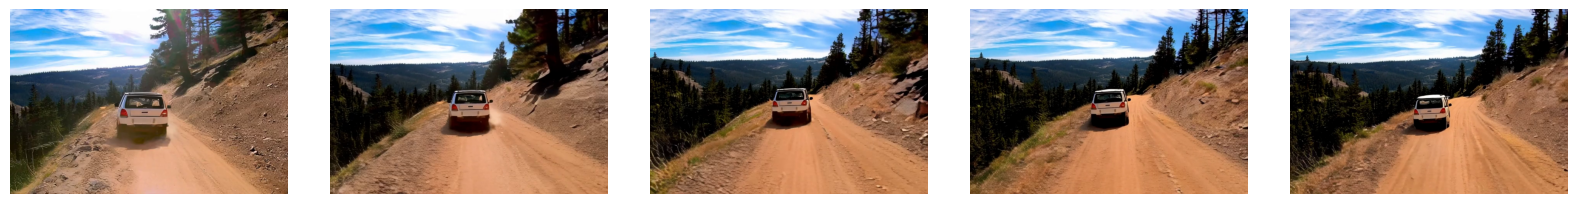

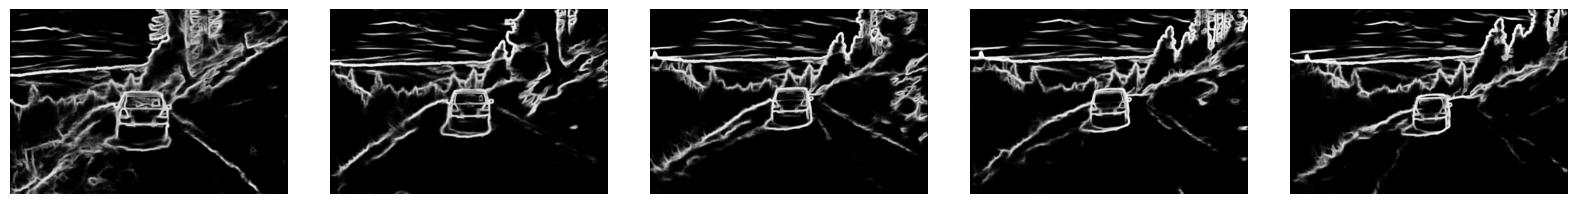

In [7]:
num_frames = 49
video_path = '../resources/car.mp4'
video_frames = load_video(video_path)[:num_frames]
controlnet_frames = [controlnet_processor(x) for x in video_frames]

show_images(video_frames[::10], figsize=(16, 8))
show_images(controlnet_frames[::10], figsize=(16, 8))

In [14]:
output = pipe(
    controlnet_frames=controlnet_frames,
    prompt='The camera follows behind a white vintage SUV',
    height=480,
    width=720,
    num_frames=num_frames,
    guidance_scale=6,
    num_inference_steps=50,
    generator=torch.Generator(device="cuda").manual_seed(42),
    controlnet_weights=1.0,
    controlnet_guidance_start=0.0,
    controlnet_guidance_end=1.0,
)

  0%|          | 0/50 [00:00<?, ?it/s]

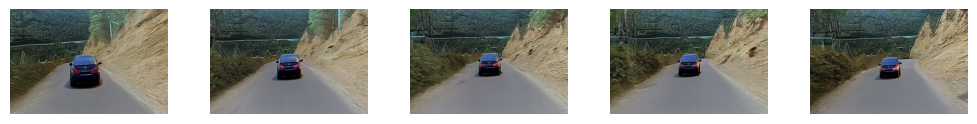

In [9]:
show_images(output.frames[0][::10], figsize=(10, 10))

In [15]:
export_to_video(output.frames[0], 'out.mp4', fps=16)

'out.mp4'

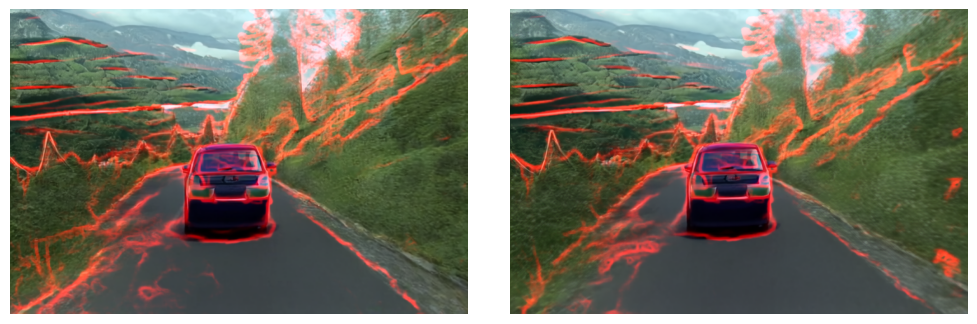

In [16]:
np_predict = [np.array(x) for x in output.frames[0]]

masked_images = [
    add_mask_on_image(
        np.array(image), 
        np.array(mask.resize((720, 480))), 
        color=(255, 0, 0)
    ) 
    for image, mask in zip(np_predict, controlnet_frames)
]
show_images(masked_images[:2], figsize=(10, 10))

In [17]:
export_to_video([Image.fromarray(x) for x in masked_images], 'masked_out.mp4', fps=16)

'masked_out.mp4'